# Predicting Whether or Not a MineCraft Player is Subscribed to a Gaming Newsletter #

**Group 9: Lilien B, Colin K, Lara M, Palmer W**
  

# Introduction: #

Player engagement in video games is a valuable metric as game developers seek to foster a wider community to create a more enjoyable player experience. One way to maintain player engagement is to subscribe to gaming newsletters as it continually updates players on new information and updates that come to the game. Thus, it would be helpful to see what factors contribute to players being subscribed to a newsletter. However, it can be a challenge to predict what player behaviours will lead to maximum player engagement, such as a subscription to a newsletter. By building a classification model, it will allow developers to use game statistics to see and predict if the player is subscribed to the newsletter.

Classification is the practice of categorizing things based on previous observations or variables. This is useful in data science as it allows us to predict and characterize observations without a known class. By building a classification model, we try to predict if a player is subscribed to the newsletter based on other variables. To build a model to perform the classification, we used a data set collected by researchers at UBC about play sessions of participants in a Minecraft server. With this dataset we plan to answer the question: Can played hours and age predict whether a player is subscribed to a gaming newsletter? The dataset contains player information including experience, if they are subscribed to the newsletter, a hashed email, played hours, name, gender, and age. From these variables, we will use played hours, age and if they are subscribed to the newsletter to train a classifier model.


# Method: #

Firstly, we will load the tidyverse and tidymodels packages to provide the functions we will use for this project. Next, let's load the players dataset using the read_csv function. Additionally, we will use the drop_na() function to get rid of rows containing N/A values. 

In [10]:
library(tidyverse)
library(tidymodels)

tidy_players <- read_csv("https://raw.githubusercontent.com/pwelters/dsci_project_data/refs/heads/main/players.csv") |>
    drop_na()

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


The dataset is now loaded and we can visualize relationship between, played hours, age and whether the player is subscirbe to the newsletter. In order for the code to be reproducible, we will use set.seed to ensure all random processes are the same no matter who runs the code. This will be continued throughout the analysis. To visualize the data, we will use ggplot2 package, but first we need to change the subscibe variable from a character value to a factor. After, we will plot the data with age on the x axis and hours played on the y axis with the color of the data points being colored based on is the player is subscribed.

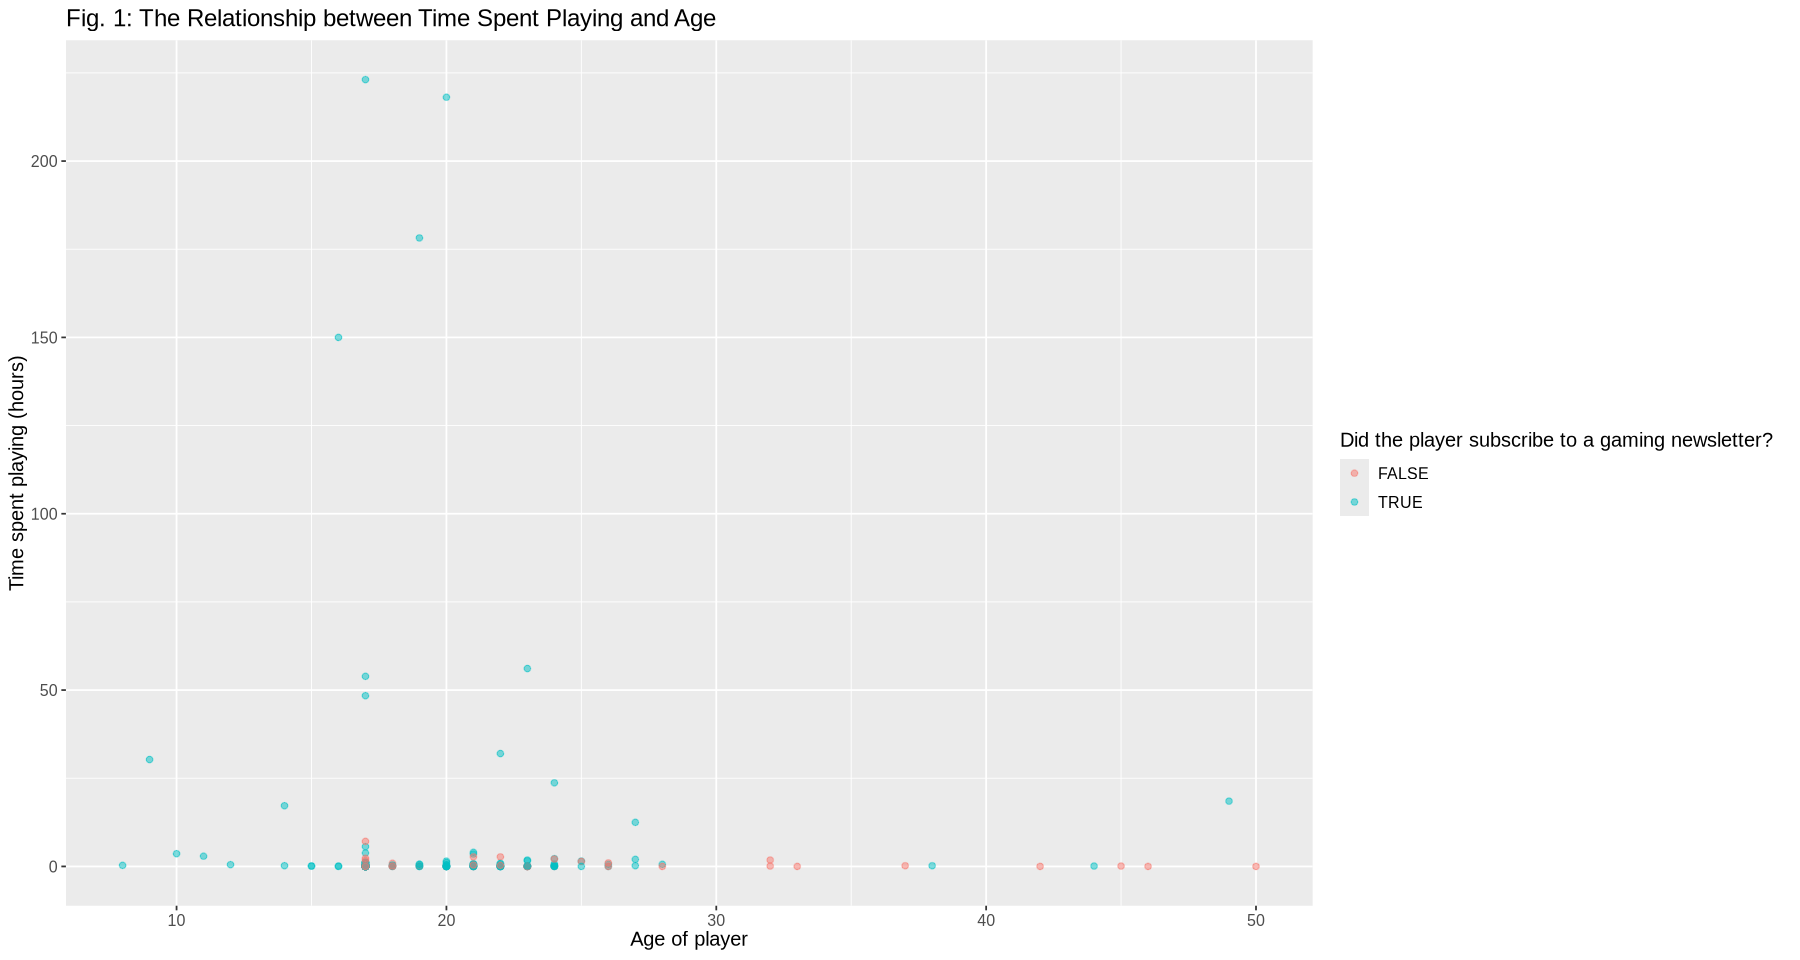

In [11]:
# set the seed
set.seed(1)

# load data
tidy_players <- tidy_players |>
    mutate(subscribe = as_factor(subscribe))

# create scatter plot of age versus played hours,
# labeling the points by subscribe class

time_age_plot <- tidy_players |>
    ggplot(aes( x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.5) +
    labs( x = "Age of player", y = "Time spent playing (hours)", color = "Did the player subscribe to a gaming newsletter?") +
    ggtitle("Fig. 1: The Relationship between Time Spent Playing and Age") +
    theme(text = element_text(size = 12))

time_age_plot

Before splitting the data into a training set and a testing set, the proportions of the two subscribe variables are determined to ensure that the training and testing sets both have the same proportion of TRUE and FALSE responses. This allows the training and testing sets to be more representative of the actual data as the ratio between the two different responses will be the same.

In [12]:
# Ratio of subscribed and unsubscribed players to ensure that the proportion is maintained when splitting into training and testing groups
og_proportions <- tidy_players |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(tidy_players))

og_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


The data is now split into the training and testing sets, with 75% of the data going into the training set (subscribe_train) and 25% going into the testing set (subscribe_test). Each set is checked to ensure that the proportions remain the same as in the original data set.

In [13]:
set.seed(2)
#splitting data into training and testing groups, maintaining original proportions

subscribe_split <- initial_split(tidy_players, prop = 0.75, strata = subscribe)
subscribe_train <- training(subscribe_split)
subscribe_test <- testing(subscribe_split)

subscribe_train_proportions <- subscribe_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_train))

subscribe_test_proportions <- subscribe_test |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(subscribe_test))

subscribe_train_proportions
subscribe_test_proportions

#we can confirm that the proportions are preserved

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,13,26.53061
TRUE,36,73.46939


An initial recipe, classification model and workflow are created to train the training set for cross validation. The recipe specifies the class variable that the classifier is trying to predict, indicates which variables are to be used as predictors, and scales both predictors to make sure they contribute equally to the classification. 

The knn_spec model specifies the number of neighbors, sets the engine to kknn and sets the mode to classification. A K value of five was initially set for the number of neighbors, however this is simply to train the classifier for cross validation which will pick the most accurate K value to be used when classifying the testing set.

Finally, the knn_fit workflow combines the recipe and model and fits them onto the subscribe_train set to train the classifier.

In [14]:
#recipe
subscribe_recipe <- recipe(subscribe ~ Age + played_hours, data = subscribe_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


 knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
     set_engine("kknn") |>
     set_mode("classification")

 knn_fit <- workflow() |>
     add_recipe(subscribe_recipe) |>
     add_model(knn_spec) |>
     fit(data = subscribe_train)

 knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3931034
Best kernel: rectangular
Best k: 5

A five fold cross validation is conducted to determine the best K value. This splits the data into five chunks, each of which has a different validation set that the classification model is tested on. The k_vals tibble specifies the range of K values that will be tested to find the optimal number of neighbors for the classifier. In this case, K values from 1 to 50 will be tested. These are then all combined into the tune_fit workflow which will test each validation set.

In [15]:
set.seed(3)
subscribe_vfold <- vfold_cv(subscribe_train, v = 5, strata = subscribe)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn")|>
set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

tune_fit <- workflow() |>
add_recipe(subscribe_recipe) |>
add_model(knn_tune)|>
tune_grid(resamples = subscribe_vfold, grid = k_vals) |>
collect_metrics()

The accurate_k object filters the tune_fit workflow by accuracy, and then a scatter plot is created of all the different K values used and their individual accuracies when tested on the validation sets. A line is added to the plot to better display the relationship between K value and accuracy. 

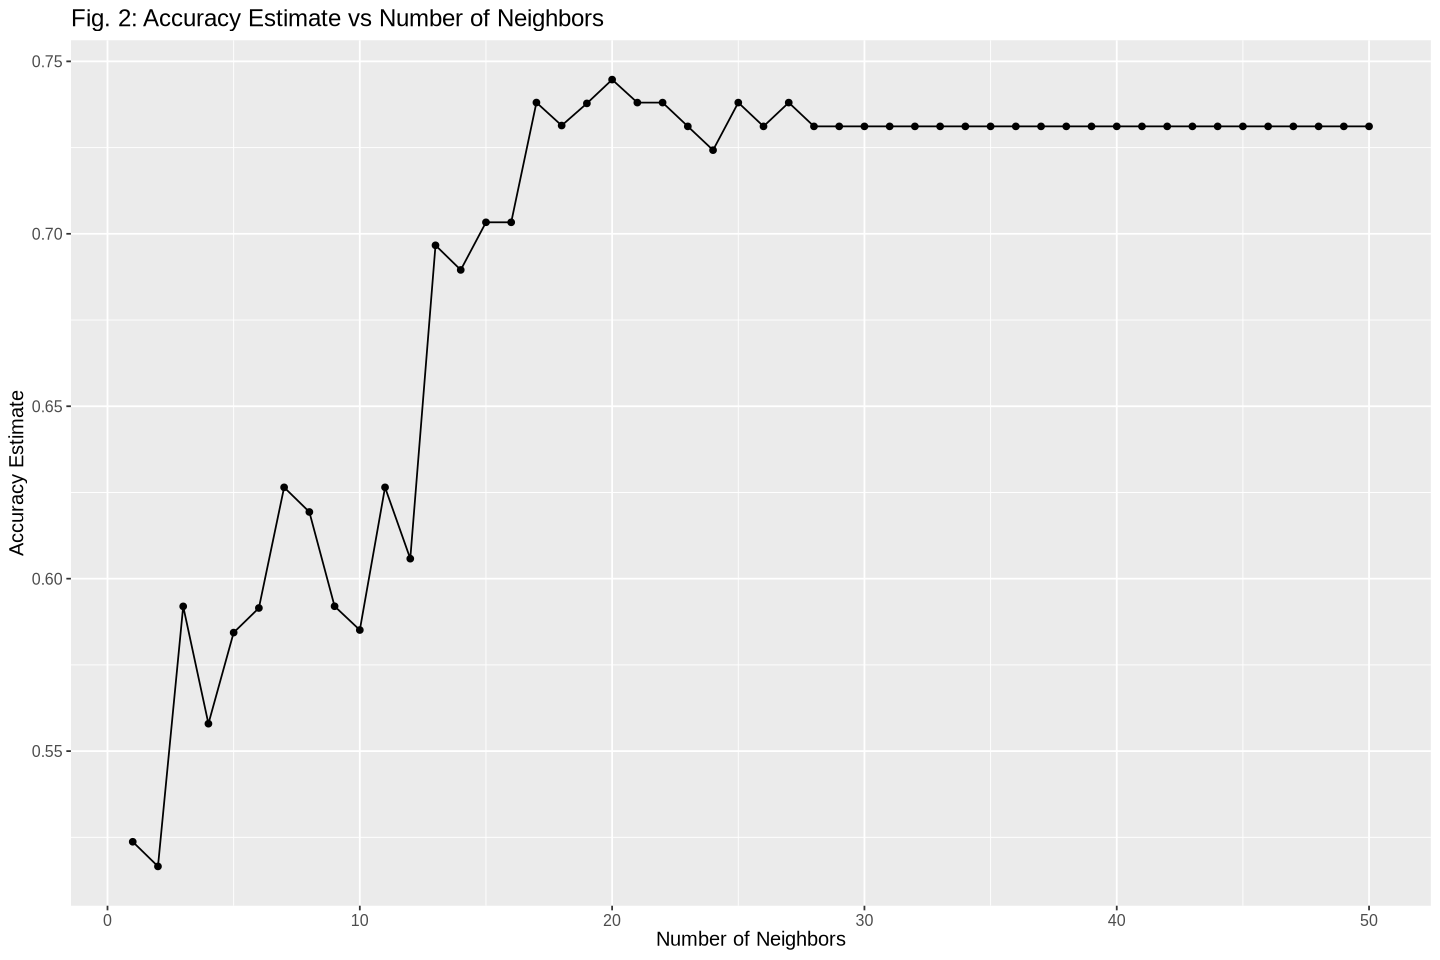

In [16]:
set.seed(4)
accurate_k <- tune_fit |>
filter(.metric == "accuracy")

options(repr.plot.width = 12, repr.plot.height = 8)
k_accuracy_plot <- ggplot(accurate_k, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Number of Neighbors", y = "Accuracy Estimate") +
    ggtitle("Fig. 2: Accuracy Estimate vs Number of Neighbors")+
  theme(text = element_text(size = 12))

k_accuracy_plot

While the graph in Fig. 2 visualizes the relationship between K value and accuracy, the best_k_value object was created to arrange the K values in descending order based on their accuracy and return a single K value from the top of the list. This K value will be used in the final classifier that is used on the testing set.

In [17]:
best_k_value <- accurate_k |>
arrange(desc(mean)) |>
head(1) |>
pull(neighbors)

best_k_value

[1] 20

The classifier is now re-trained using the chosen K value of 20 from cross validation. The best_knn_spec model incorporates this K value and the final_knn_fit workflow combines it with the training set.

In [18]:
set.seed(5)
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) |>
set_engine("kknn")|>
set_mode("classification")

final_knn_fit <- workflow() |>
add_recipe(subscribe_recipe)|>
add_model(best_knn_spec)|>
fit(data = subscribe_train)

The final workflow is now used to make predictions on the testing data and its accuracy is determined.

In [19]:
subscribe_test_predictions <- predict(final_knn_fit, subscribe_test) |>
bind_cols(subscribe_test)

subscribe_test_predictions |> metrics(truth = subscribe, estimate = .pred_class) |>
filter(.metric == "accuracy")


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


A confusion matrix is generated to determine the precision and recall of the classifier

In [23]:
confusion_matrix <- subscribe_test_predictions |>
conf_mat(truth = subscribe, estimate = .pred_class)

confusion_matrix


          Truth
Prediction FALSE TRUE
     FALSE     0    1
     TRUE     13   35

The confusion matrix shows that 35 out of 36 true observations were correctly identified, whereas all of the false observations were labelled true in our prediction.

Now the majority class is calculated. The majority class shows the accuracy of predicting the most prominent variable (in this case the TRUE variable) for each observation. As the majority class classifier is typically similar to the majority class proportion of the training data, we can expect the majority classifier to be 73%. This indicates that the majority class identifier is slightly better than the K-nearest neighbours classifier in terms of accuracy.

In [22]:
subscribe_train_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


# Discussion: #